# Tarea5

### Rodolfo Arturo González Trillo

In [1]:
using Plots, LaTeXStrings, TaylorSeries
include("AutomDiff_V2.jl")
import AD: Dual, xdual
pyplot(grid=:false, size=(800,600))

Plots.PyPlotBackend()

**Ejercicio 1:**

Obtengan, para la familia de mapeos cuadrática $Q_c(x)$, el exponente de Lyapunov en términos de $c$.

Utilizamos la función estándar del mapeo, como referencia para otras funciones.

In [2]:
function mapeo1D(F, x_0, c, n)
    @assert n ≥ 1
    
    x = x_0
    for i in 1:n
        x = F(x,c)
    end
    x
end

mapeo1D (generic function with 1 method)

El índice de Lyapunov está definido como:
\begin{equation}
\lambda(x_0)=\frac{1}{n} \sum_{i=1}^n \log\Big| \, f'(x_i)\, \Big|
\end{equation}

Definimos las funciones $Q_c^n(x)$

In [3]:
Qc(x,c) = x^2 + c

doc"""
    Qcⁿ(x, args)

Esta función define el n-enésimo iterado de $Qc(x,c)$,
donde el valor a iterar es `x` y el valor del parámetro
es `c`, donde `c = args[1]` y `n = args[2]`.
"""
function Qcⁿ(x, args)
    c, n = args[1], args[2]
    @assert n >= 0 && isa(n,Int)
    n <= 1 && return Qc(x,c)
    for it = 1:n
        x = Qc(x,c)
    end
    return x
end

Qcⁿ

Definimos la función $\lambda(x_0)$:

In [4]:
doc"""
    mapeo1D_λ(F, x_0, c, n)

Cálcula el índice de Lyapunov para un mapeo definido por `F(x,c)` 
con $x_0$, inicial, para la constante `c` propocionada hasta `n`
mediante $\frac{1}{n} \sum_{i=1}^n \log\Big| \, f'(x_i)\, \Big|.$

"""

function mapeo1D_λ(F, x_0, c, n)
    @assert n ≥ 1
    
    x = x_0
    sum = 0.0
    Fi(x) = F(x,c)
    
    for i in 1:n
        x = Fi(x)
        sum = sum + log(abs((Fi(xdual(x))).der))
    end
    
    sum/n

end

mapeo1D_λ

Con la función para calcular el índice de Lyapunov para cierta $c$ procedemos a calcular para distintas C's y graficar.

In [5]:
#Intervalo de constantes.
cs = 0.25:-1/2^14:-2.0
λs = Float64[]

#Valores de la función de Lyapunov alrededor de 1.0
for c in cs
    λc = mapeo1D_λ(Qc, 1.0, c, 5000)
    
    if abs(λc)==Inf #En algunos puntos labda diverge, por lo que si tiende a infinito, se la asigna el valor-2.5
        push!(λs,-2.5)      
    else
        push!(λs,λc)    
    end
end


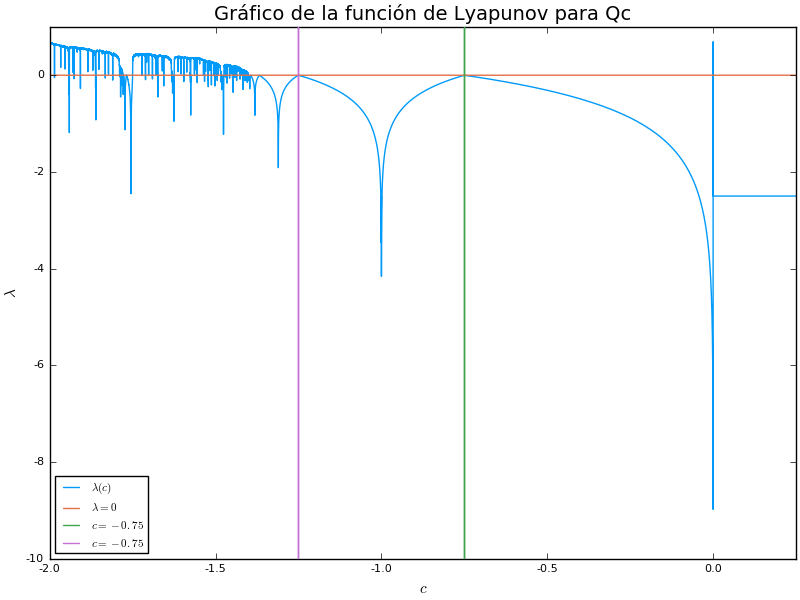

In [6]:
plot(cs, λs, label=L"\lambda(c)")
plot!(cs, x->0, label=L"\lambda=0")
plot!([-0.75,  -0.75], [1, -10, 1],label=L"c=-0.75")
plot!([-1.25,  -1.25], [1, -10, 1],label=L"c=-0.75")
xlabel!(L"c")
ylabel!(L"\lambda")
title!("Gráfico de la función de Lyapunov para Qc")

De la tarea pasada, los primeros dos valores de bifurcación son -0.75 y -1.25. Aproximandonos al 0.75 observamos que ocurre un cambio súbito de pendiente, aprovechamos el gráfico anterior para mostrar su ubicación. Vemos que la función de Lyapunov tiene valores $\lambda=0.0$ en esos puntos. Usando esta propiedad, podemos terminar de graficar puntos cuando se cumple la condición de que $\lambda \geq 0.0$.

Definimos la función `mapeoλ`.

In [7]:
function mapeoλ(F::Function, x_0::Float64, crange)
   
    λs = Float64[]
    N = 100000

    #Valores de la función de Lyapunov alrededor de x_0
    for c in crange
        λc = mapeo1D_λ(Qc, x_0, c, N)
    
        if λc < 0.0 #Condición para detener la función.
            if abs(λc)<Inf
                push!(λs,λc)      
            else
                push!(λs,-2.5)       
            end            
        else
            break
        end

    end
    λs        
end

mapeoλ (generic function with 1 method)

- ¿Qué particularidad ocurre (en términos del exponente de Lyapunov) cuando tenemos *ciclos superestables*, es decir, cuando $x=0$ es parte de un ciclo periódico?

Los puntos superestables conocidos están en $c= -1,-1.3107 $, los marcamos en el gráfico.

In [8]:
cs  = -(0.75-1/2^16):-1/2^16:-1.405
x_0 = 1.0
λs  = mapeoλ(Qc, x_0, cs);


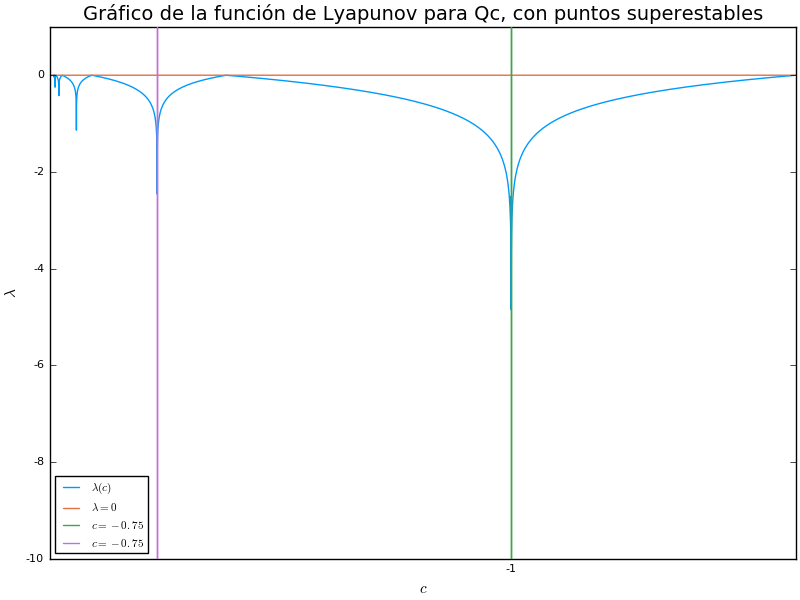

In [9]:
plot(cs, λs, label=L"\lambda(c)")
plot!(cs, x->0, label=L"\lambda=0")
plot!([-1.0,  -1.0], [1, -10, 1],label=L"c=-0.75")
plot!([-1.3107,  -1.3107], [1, -10, 1],label=L"c=-0.75")
xlabel!(L"c")
ylabel!(L"\lambda")
title!("Gráfico de la función de Lyapunov para Qc, con puntos superestables")

Obsevamos que en los puntos super estables, la función diverge.

**Ejercicio 2:**

Rehacer los cálculos de los exponentes de Feigenbaum,
\begin{eqnarray*}
f_n &=& \frac{C_n-C_{n+1}}{C_{n+1}-C_{n+2}},\\
a_n &=& \frac{d_n}{d_{n+1}},
\end{eqnarray*}

usando los valores $C_n$ donde se tienen ciclos superestables de periodo $2^n$. (Este ejercicio es muy parecido a los ejercicios 1 y 3 de la `Tarea4`.)

En el ejercicio anterior observamos que los puntos superestables ocurren en los máximos locales de $\lambda$, se requiere una función que encuentre máximos locales.

In [10]:
function maximos_locales(arreglo::Array, crange)
    
    n = length(arreglo)
    cs = Float64[]
    ϵ = 5e-4
    
    for i in 2:n-1
        if (abs(arreglo[i+1]) < abs(arreglo[i]) > abs(arreglo[i-1])) #Condición para un punto máximo
            if length(cs)==0 || abs(crange[i]-last(cs))>ϵ
                push!(cs,(crange[i])) #guarda el punto del rango en el cual ocurre el máximo
            end
        end
    end
    
    cs
    
end

maximos_locales (generic function with 1 method)

In [11]:
cs1 = maximos_locales(λs, cs)

6-element Array{Float64,1}:
 -0.999985
 -1.3107  
 -1.38155 
 -1.39694 
 -1.40025 
 -1.40096 

Utilizamos la función de método de Newton, empleando la derivada instantánea, y la función para Qc de clases.

In [12]:
doc"""
    newton(f, adiv, ϵ = 1e-10)

Realiza el método de Newton para una función $f$ dada una adivinanza 'adiv' 
con una tolerancia de '1e-10' o a la 1000-ésima iteración
"""
function newton{T<:Real}(f::Function, adiv::T, ϵ = 1e-10)
    x0 = xdual(adiv)
    fx = f(x0)
    k = 0
    
    while abs(fx.fun) > ϵ
        k = k+1
        it = x0.fun - fx.fun/fx.der
        x0 = xdual(it)
        fx = f(x0)
        
        if count == 1000
            break
        end
    end
    
    return x0.fun
end



newton

In [13]:

doc"""
    puntos_sestables!(Fcⁿ,cs)

Usando el método de Newton encuentra el conjunto de puntos superestables.
"""

function puntos_sestables!(Fcⁿ, cs)
    
    for i in 1:length(cs)
        
        Fc = c -> Fcⁿ(0.0, (c, 2^i)) #Redefinición de la función        
        cs[i] = newton(Fc, cs[i]) #Se aplica el método de Newton
    end
    cs
end

puntos_sestables!

In [14]:
puntos_sestables!(Qcⁿ,cs1)

6-element Array{Float64,1}:
 -1.0    
 -1.3107 
 -1.38155
 -1.39695
 -1.40025
 -1.40096

Ahora, buscamos la secuencia $f_n$ con:
$$f_n = \frac{C_n-C_{n+1}}{C_{n+1}-C_{n+2}}$$

In [15]:
f(C,n) = (C[n]-C[n+1])/(C[n+1]-C[n+2])

[f(cs1,i) for i in 1:length(cs1)-2]

4-element Array{Float64,1}:
 4.38568
 4.60095
 4.65513
 4.66611

Se obtiene un valor de  $f=4.66611$, comparado con el valor real de $f=4.66920$

Ahora $d_n = \left| \ f^{n}(x_0+\epsilon)-f^{n}(x_0)\right| $

In [16]:
function mapeo1D_arreglo(F, x_0, c, n)
    @assert n ≥ 1
    
    x = x_0
    xs=[x]
    
    for i in 1:n
        x = F(x,c)
        push!(xs,x)
    end
    xs
end

mapeo1D_arreglo (generic function with 1 method)

In [17]:
doc"""
ds(cs)

Obtiene el iterado de la longitud de su órbita para un arreglo de puntos super estables.
"""
function ds(F,x_0,cs)
    
    resultados = Float64[] #almacena
    
    for i in 1 : length(cs)
        d = minabs( deleteat!(mapeo1D_arreglo(F, x_0, cs[i], 2^(i-1) ),1) )
        push!(resultados,d)
    end
    
    resultados
end


ds

In [18]:
des = ds(Qc,0.0,cs1)

6-element Array{Float64,1}:
 1.0      
 0.407239 
 0.163425 
 0.0653634
 0.0261213
 0.0104369

In [19]:
as=[des[i]/des[i+1] for i in 1:length(des)-1]

5-element Array{Float64,1}:
 2.45556
 2.49189
 2.50026
 2.50231
 2.50277

Se obtiene $a=2.50277$ , comparado con el valor real de $a=2.50291$.

**Ejercicio 3:**

Comparar gráficamente los mapeos $Q_{c}(x)$ y $Q_{c^\prime}^2(x)$ para $c=1/4, 0, -3/4, -1, -2, -2.2$ y $c^\prime=-3/4,-1,-5/4,-1.3, -1.546\dots, -1.65$. 



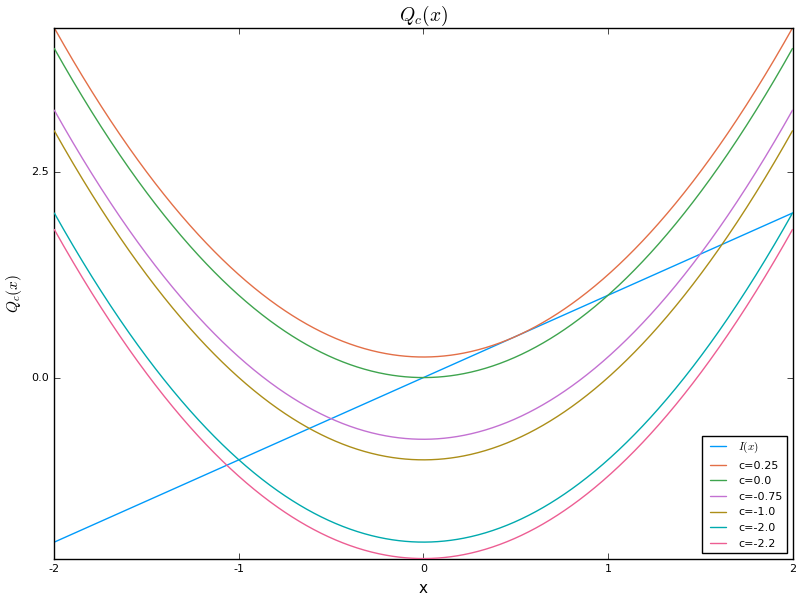

In [20]:
xs = -2.0:1/2^8:2.0

c  = Float64[1/4,  0,-3/4,  -1,    -2, -2.2]
c´ = Float64[-3/4,-1,-5/4,-1.3,-1.546,-1.65]

plot(xs, identity, label = L"I(x)")

for ci in c
    plot!(xs, x->Qcⁿ(x, (ci, 1)), label="c=$ci")
end

xlabel!("x")
ylabel!(L"Q_{c}(x)")
title!(L"Q_{c}(x)")

Para $c=0.25$ el mapeo solamente tiene un punto fijo, para valores menores, el mapeo tiene dos puntos fijos. 


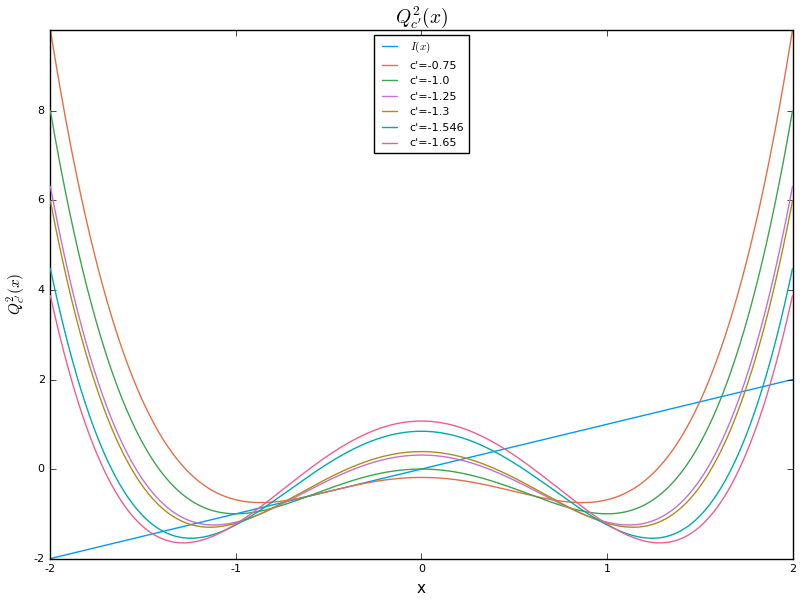

In [21]:
plot(xs, identity, label = L"I(x)")

for ci in c´
    plot!(xs, x->Qcⁿ(x, (ci, 2)), label="c'=$ci")
end

xlabel!("x")
ylabel!(L"Q_{c^\prime}^2(x)")
title!(L"Q_{c^\prime}^2(x)")

Observamos en el gráfico que los valores de $-Q_{c^\prime}^2(x)$ son osculantes a la parábola  $Q_{c}(x)$con $c=0.25$

**Ejercicio 4:**

Estudiar la dinámica para $c=-2.2$

- ¿Cómo se caracteriza el valor al que tiende *casi* cualquier condición inicial en el
intervalo $I=[-p_+,p_+]$ (donde $p_+$ es el valor positivo tal que $Q_c(p_+)=p_+$), después de muchos iterados? (El intervalo $I$ es donde "toda la dinámica interesante ocurre".)

$Q_c = x^2 + c $

El intervalo $I$ es $\left[- \frac{1}{10} \left( 5+7\sqrt{5} \right),\frac{1}{10} \left( 5+7\sqrt{5} \right) \right]$

Encontramos los puntos con numéricamente con:

In [22]:
p₊ = newton(x -> Qc(x, -2.2) - x, 1)

2.0652475842498528

In [23]:
rango1 = -p₊:1e-6:p₊

it1 = [mapeo1D(Qc, x, -2.2, 5000) for x in rango1]

4130496-element Array{Float64,1}:
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
   ⋮
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf
 Inf

In [24]:
unique(it1)

1-element Array{Float64,1}:
 Inf

Todos los elementos se van a infinito, salen del intervalo $I$. Requerimos buscar TODOS los elementos que se salen del intervalo.

In [25]:
function busqueda( F::Function, c, rango::FloatRange, n = 10)
    
    res1 = Float64[]
    res2 = Float64[]
    
    xmin = rango[1]
    xmax = last(rango)
    
    
    for j in 1:length(rango)
        x0 = rango[j]
        
        for k in 1:n
            x0 = F(x0,c)
            if !(xmin <= x0 <= xmax)
                push!(res1, rango[j])
                push!(res2, k)                
                
                break
            end
        end
    end
    
    
    res1,res2
end

busqueda (generic function with 2 methods)


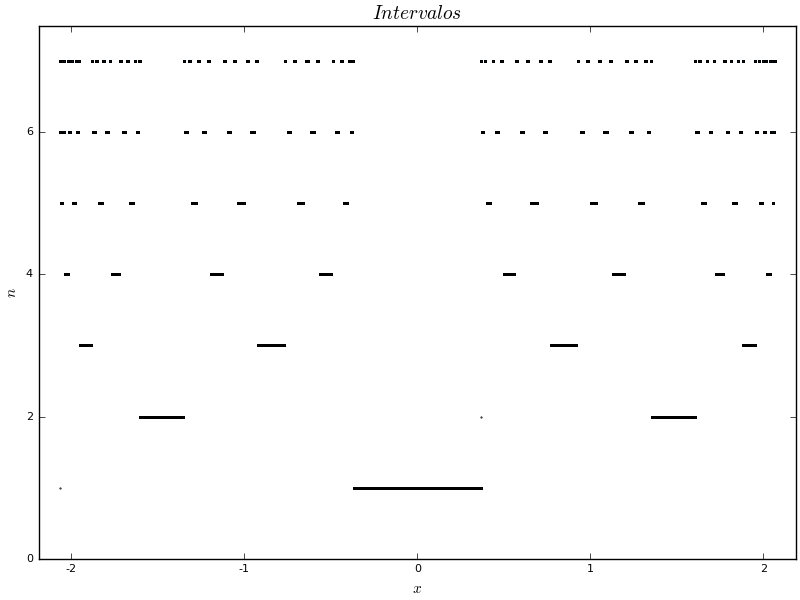

In [26]:
xs1, ys1 = busqueda( Qc, -2.2, rango1, 10);

scatter(xs1, ys1, legend = :false, markersize = 0.5)
xlabel!(L"x")
ylabel!(L"n")
title!(L"Intervalos")
ylims!(0, 7.5)

- Caractericen los subconjuntos de $I$ tales que, después de $n=1,2,3,\dots$ iterados de $Q_c(x)$, su intersección con $I$ es vacía.

- Caracterizen al complemento del conjunto de los casos anteriores, es decir, cuando los iterados de la condición inicial **no** llegan a donde *casi* cualquier condición inicial termina. ¿Cómo se conoce a este conjunto?

Observamos que en el intervalo $I$, los puntos  salen después de la $n$-ésima iteración, vemos que estos subconjuntos son complementos de los conjuntos $C_n$, es decir, los conjuntos que inducen al conjunto de Cantor (dado por $\bigcap_{n \in \mathbb{N}} C_n$) en dicho intervalo.

**Ejercicio 5:**

- Usando el análisis gráfico para un valor de $c$ *ligeramente* anterior al punto donde se observa la ventana de periodo 3 para la familia $Q_c(x)$, y uno en la ventana de periodo 3, concluyan el tipo de bifurcación que se observa.

Primero hay que hacer el diagrama de bifurcaciones para el intervalo, para tal próposito, reciclamos las funciones de Benet.

In [27]:
"""
    ciclosestables!(xx, f, nit, nout, cc)

Esta función itera el mapeo `f`, de una variable, `nit+nout` veces, 
usando como condición inicial `x0=0`; los últimos `nout` iterados 
actualizan al vector `xx` que tiene longitud `nout`. `cc` es el valor
del parámetro del mapeo `f`. El mapeo `f` debe ser definido de 
tal manera que `f(x0,cc)` tenga sentido. La idea es los últimos 
`nout` iterados reflejen los ciclos estables del mapeo `f`. 
"""
function ciclosestables!(xx, f, nit, nout, cc)
    @assert nit > 0 && nout > 0
    
    # Primeros nit iterados
    x0 = 0.0
    for it = 1:nit
        x0 = f(x0, cc)
    end
    
    # Se guardan los siguientes nout iterados
    for it = 1:nout
        x0 = f(x0, cc)
        @inbounds xx[it] = x0
    end
    
    nothing
end

ciclosestables!

In [28]:
"""
    diagbifurc(f, nit, nout, crange)

Itera el mapeo `f` `nit+nout` veces y regresa una matriz
cuya columna `i` tiene los últimos `nout` iterados del mapeo
para el valor del parámetro del mapeo `crange[i]`.

La función `f` debe ser definida de tal manera que `f(x0, c)` 
tenga sentido.
"""
function diagbifurc(f, nit, nout, crange)
    xx = Vector{Float64}(nout)
    ff = Array{Float64,2}(nout, length(crange))
    
    for ic in eachindex(crange)
        c = crange[ic]
        ciclosestables!(xx, f, nit, nout, c)
        ff[:,ic] = xx
    end
    
    return ff
end

diagbifurc

- Comparen la dinámica para ambos valores de $c$ del inciso anterior. ¿Cómo es el exponente de Liapunov en cada caso?

Usamos el intervalo de $c \in [-1.74,-1.8]$, donde se encuentra la bifurcación.

In [29]:
crange = -1.74:-1/2^12:-1.8

ff = diagbifurc(Qc, 1000, 256, crange); 
cc = ones(size(ff)[1])*crange';

# Esto cambia las matrices en vectores; ayuda un poco para los dibujos
ff = reshape(ff, size(ff)[1]*size(ff)[2]);
cc = reshape(cc, size(ff));


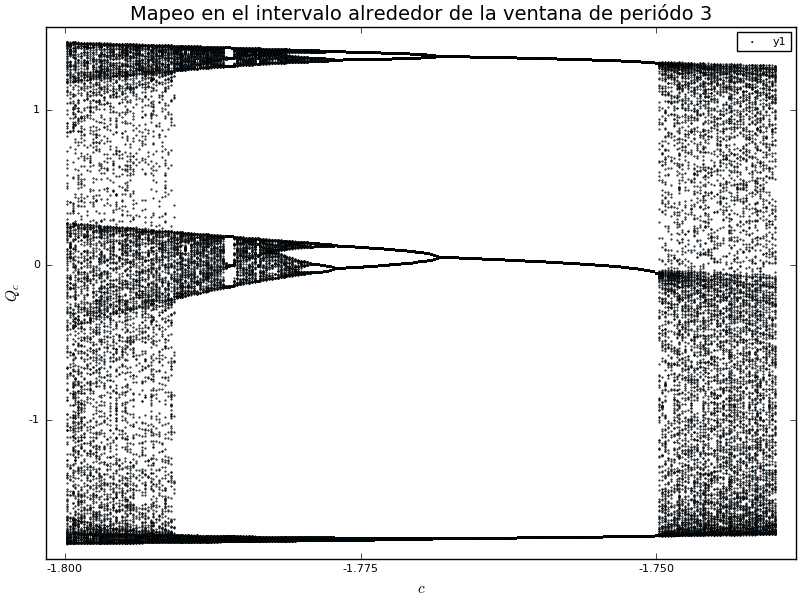

In [30]:
scatter(cc,ff, markersize = 0.5)
xlabel!(L"c")
ylabel!(L"Q_c")
title!("Mapeo en el intervalo alrededor de la ventana de periódo 3")

Se observan tres ramas después de la bifurcación se trata de una bifrucación de óbita que ocurre en 1.75.

Hay que encontrar el gráfico de la función de Lyapunov, redefinimos la función del mapeo λ quitando la condición de que sea negativa, causaba algunos problemas al graficar.

In [31]:
function mapeoλ(F::Function, x_0::Float64, crange)
   
    λs = Float64[]
    N = 100000

    #Valores de la función de Lyapunov alrededor de x_0
    for c in crange
        λc = mapeo1D_λ(Qc, x_0, c, N)
    
        #if λc < 0.0 #Condición para detener la función.
            if abs(λc)<Inf
                push!(λs,λc)      
            else
                push!(λs,-2.5)       
            end            
        #else
            #break
        #end

    end
    λs        
end

mapeoλ (generic function with 1 method)

In [32]:
cr2 = -1.7:-1/2^16:-1.8
x_0 = 1.0
λs2  = mapeoλ(Qc, x_0, cr2);


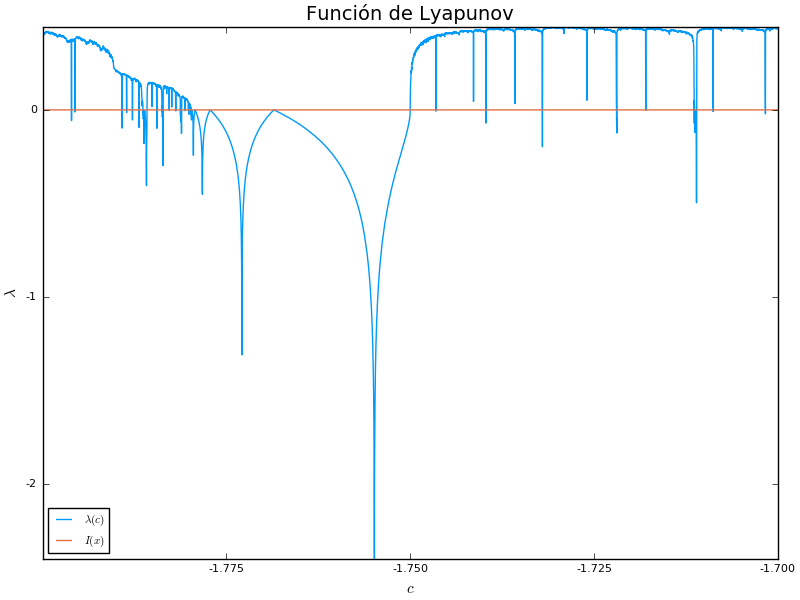

In [33]:
plot( cr2, λs2, label = L"\lambda(c)" )
plot!( cr2, x->0, label = L"I(x)")
xlabel!(L"c")
ylabel!(L"\lambda")
title!("Función de Lyapunov")

Hay un cambio de signo en $c=-1.75$. La forma es la misma que en el caso inicial.

- Encuentren el valor de $c$ donde se da el ciclo superestable de periodo 3. (Nuevamente, ayuden al método de Newton con una buena semilla inicial para $c$.) Demuestren que para este valor de $c$ el mapeo $Q_c^3(x)$ tiene *ocho* puntos fijos, donde dos de ellos son puntos fijos de $Q_c(x)$, y los otros 6 forman dos secuencias periódicas, de periodo 3 en $Q_c(x)$, una de ellas estable y la otra inestable.

In [34]:
max = maximum(abs(λs2))
i = 0
for i in 1:length(cr2)
    if abs(λs2[i])==max
        break
    end
end
se3 = cr2[i]

-1.75487060546875

Refinamos con `newton`:

In [35]:
Q3c = c -> Qcⁿ(0.0, (c, 3))
se3 = newton(Q3c, se3)

-1.7548776662466927

El ciclo superestable de $Q_c^3$ se encuentra en $c=-1.7548776662468835$.

Graficamos el mapeo para esa $c$, para en observar los puntos fijos.


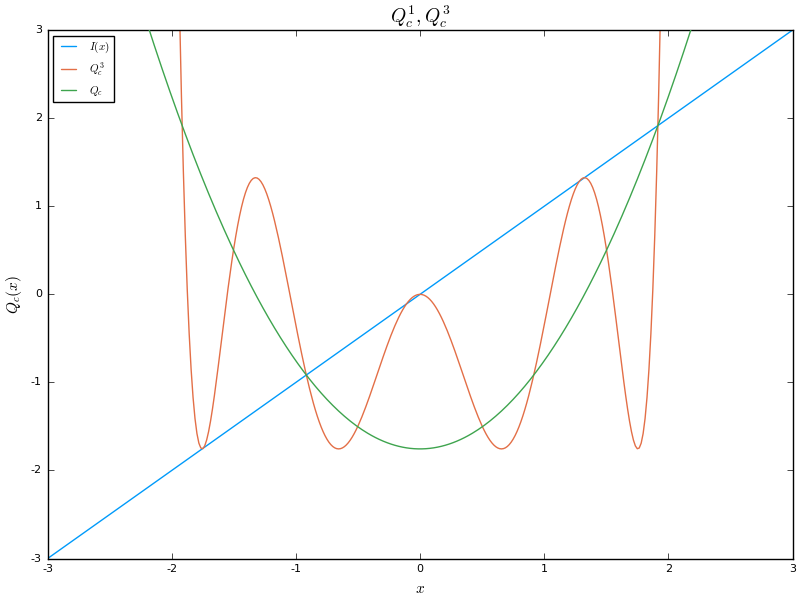

In [36]:
xrange = -3:1/64:3

plot(xrange, x->x, label=L"I(x)")
plot!(xrange, x->Qcⁿ(x, (se3,3)), label=L"Q_c^3")
plot!(xrange, x->Qcⁿ(x, (se3,1)), label=L"Q_c")

ylims!(-3,3)
xlabel!(L"x")
ylabel!(L"Q_c(x)")
title!(L"Q_c^1, Q_c^3")

A ojo, hacemos un arreglo de adivinanzas.

In [37]:
radv=[-1.8,-1.7,-0.9,-0.1,0.0,1.2,1.4,2.0]

8-element Array{Float64,1}:
 -1.8
 -1.7
 -0.9
 -0.1
  0.0
  1.2
  1.4
  2.0

In [38]:
#Encontramos los 8 puntos con las observaciones.
F3 = x -> (Qcⁿ(x, (se3, 3))-x)
p8 = [newton(F3, a) for a in radv]

8-element Array{Float64,1}:
 -1.75488 
 -1.74285 
 -0.915937
 -0.10965 
  0.0     
  1.28266 
  1.32472 
  1.91594 

Realizamos el mismo procedimiento para $Q_c^1$

In [39]:
radv=[-1,2.0]
F1 = x -> (Qcⁿ(x, (se3, 1))-x)
p2 = [newton(F3, a) for a in radv]

2-element Array{Float64,1}:
 -0.915937
  1.91594 

Como se aprecia en el gráfico, los puntos fijos de $Q_c^1$ están contenidos en $Q_c^3$.

Comprobamos la estabilidad de los otros 6 valores:

In [40]:
mapeo1D_arreglo(Qc, p8[1], se3, 3)

4-element Array{Float64,1}:
 -1.75488    
  1.32472    
  6.97886e-13
 -1.75488    

Obsevamos que se dan en un ciclo:

In [41]:
mapeo1D_arreglo(Qc, p8[2], se3, 3)

4-element Array{Float64,1}:
 -1.74285
  1.28266
 -0.10965
 -1.74285

Puntos fijos de $Q_c$ : $-0.915937, 1.91594 $

Ciclo estable : $2.22286x10^{-16}, -1.75488,  1.32472 $

Ciclo inestable: $-1.74285,  1.28266, -0.109648$

(Los siguientes incisos usan el valor de $c$ encontrado en el inciso anterior.)

- Denotando al ciclo inestable de periodo 3 como $\alpha\mapsto \beta\mapsto\gamma$, con $\gamma<\beta<\alpha$, uno puede asociar a cada uno de estos valores un valor $\hat\alpha, \hat\beta, \hat\gamma$, tales que $Q_c^3(\hat\alpha)=\alpha$, $Q_c^3(\hat\beta)=\beta$, $Q_c^3(\hat\gamma)=\gamma$. ¿Qué podemos concluir de un punto que cae en cualquiera de los intervalos $[\alpha,\hat\alpha]$, $[\beta,\hat\beta]$ y $[\hat\gamma,\gamma]$, en términos de los iterados sucesivos?

Ahora definimos los valores del ciclo inestable, en un arreglo:

In [42]:
CiP3=[p8[2],p8[4],p8[6]]

3-element Array{Float64,1}:
 -1.74285
 -0.10965
  1.28266

Aplicamos el mapeo:

In [43]:
Q3 = x->Qcⁿ(x, (se3,3))
[Q3(x) for x in CiP3]

3-element Array{Float64,1}:
 -1.74285
 -0.10965
  1.28266

No se observa diferencia.

In [44]:
big([Q3(x) for x in CiP3])-big(CiP3)

3-element Array{BigFloat,1}:
  8.417799790549906902015209197998046875000000000000000000000000000000000000000000e-11
  1.984523656517467316007241606712341308593750000000000000000000000000000000000000e-15
 -3.996802888650563545525074005126953125000000000000000000000000000000000000000000e-15

Observamos que la diferencia entre los dos valores es muy pequeña. Sin embargo, los valores que estén dentro de ese intervalo aún así deberían ser parte del ciclo inestable.

- Definiendo los intervalos $I_0=[\hat\beta, \alpha]$, $I_1=[\gamma,\beta]$, mostrar que bajo la acción de $Q_c(x)$ se cumple: (i) $Q_c(I_0) \supset I_1$, y (ii) $Q_c(I_1) \supset I_0\cup I_1$. ¿Qué propiedad *importante* de $Q_c(x)$ se utiliza aquí?

(Los intervalos $I_0$ e $I_1$, y estas propiedades, son básicos en la demostración del teorema "periodo tres implica caos".)

Se definien los intervalos requeridos:

In [45]:
I0 = [ CiP3[2],Q3(CiP3[1]) ]
I1 = [ CiP3[3], CiP3[2]];

Ralizamos los calculos requeridos:

In [46]:
I1

2-element Array{Float64,1}:
  1.28266
 -0.10965

In [47]:
Qc0 = Float64[]
for i in I0[1]:-1/2^22:I0[2]
    qc0 = Q3(i) 
    push!(Qc0,qc0) 
end

sort!(Qc0)

Qc0[1],last(Qc0)


(-1.7548776662466536,1.324717957244636)

Por lo tanto $I_1 \subset I_{Qc_0}$

El otro caso:

In [48]:
I0

2-element Array{Float64,1}:
 -0.10965
 -1.74285

In [49]:
Qc1 = Float64[]
for i in I1[1]:-1/2^22:I1[2]
    qc1 = Q3(i) 
    push!(Qc1,qc1) 
end

sort!(Qc1)

Qc1[1],last(Qc1)

(-1.7548776662466845,1.2826642737997542)

Por lo tanto $I_1 \cup I_0 \subset I_{Qc_1}$